# Libraries

In [152]:
#1. GeoPandas is a project to add support for geographic data to pandas objects (work with spatial data)
#!pip install geopandas

#2. encode categorical data
#!pip install category-encoders

#3. Local Interpretable Model-Agnostic Explanations for machine learning classifiers
#!pip install lime

In [5]:
## for data
import pandas as pd
import numpy as np

import pandas.util.testing as tm

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

## for explainer
from lime import lime_tabular

# Data Preparation

## 1 Load Dataset

In [80]:
# Define relative path to file
EDAsurvey = pd.read_csv('/content/drive/My Drive/EDA/EDAsurvey.csv')
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,RCODE,SYMBOL,DESCRIPT,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


## 2 Cleaning: drop RCODE and DESCRIPT

In [81]:
# Remove column  RCODE and DESCRIPT for ML
EDAsurvey.drop(['RCODE', 'DESCRIPT'], inplace = True, axis = 1) 
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


## 3 Spatial Analysis

### 3.0 Convert PandasDataFrame to GeoDatrame

In [ ]:
import geopandas as gpd

#convert PandasDataFrame to GeoDataFrame (needs shapely object)
#We use geopandas points_from_xy() to transform x=Longitude and y=Latitude into a list of shapely
EDAsurvey_point = gpd.GeoDataFrame(EDAsurvey, geometry=gpd.points_from_xy(EDAsurvey.x, EDAsurvey.y))

In [ ]:
EDAsurvey_point.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT,geometry
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650,POINT (508985.000 5452015.000)
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845,POINT (508975.000 5452035.000)
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531,POINT (508975.000 5452045.000)
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299,POINT (508995.000 5452005.000)
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615,POINT (508995.000 5452015.000)


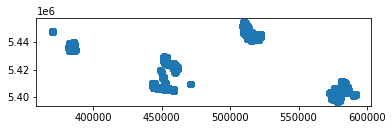

In [ ]:
#plot points cloud
EDAsurvey_point.plot()

### 3.1 Map projection

In [ ]:
from pyproj import CRS

# option 2: Defining projection: we assign the GDA94 / MGA zone 55 latitude-longitude CRS (EPSG:28355) to the crs attribute:
EDAsurvey_point.crs = CRS("EPSG:28355")
EDAsurvey_point.crs

<Projected CRS: EPSG:28355>
Name: GDA94 / MGA zone 55
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - 144°E to 150°E
- bounds: (144.0, -50.89, 150.01, -9.23)
Coordinate Operation:
- name: Map Grid of Australia zone 55
- method: Transverse Mercator
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 3.2 Plot point clouds

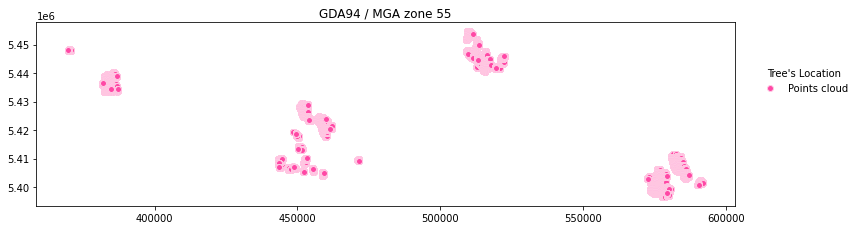

In [ ]:
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# Plot the data in WGS84 CRS
EDAsurvey_point.plot(ax=ax1, color='#ff48a5', edgecolor='#ffcae5', label="Points cloud");

# Add title
ax1.set_title("GDA94 / MGA zone 55");
ax1.legend(title="Tree's Location",loc='upper center', bbox_to_anchor=(1.1, 0.8), frameon=False)

# Remove empty white space around the plot
plt.tight_layout()

### 3.3 Write as ESRI Shape File

In [ ]:
from google.colab import files

EDAsurvey_point.to_file("EDAsurvey_point.shp")

#dowload into local machine
#files.download("EDAsurvey_point.shp")

### 3.4 Map Spatial Distribution of site index

In [1]:
#!pip install mapclassify

### 3.4.1 Map option 1

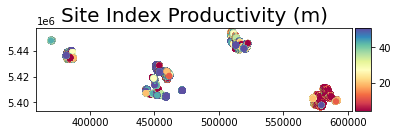

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify

# 1. MAP 1
## Plot Soil C
# set the range for the choropleth
vmin, vmax = 4, 51

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(6, 7), subplot_kw={'aspect':'equal'})

# Point data
EDAsurvey_point.plot(column='siteindex', scheme='Quantiles', k =7, cmap='Spectral', alpha=1, markersize=30, ax=ax)

# add a title
ax.set_title('Site Index Productivity (m)', fontdict={'fontsize': '20', 'fontweight' : '3'})

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
# You need to import mpl_toolkits.axes_grid1 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Spectral',
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

### 3.4.2 Map option 2

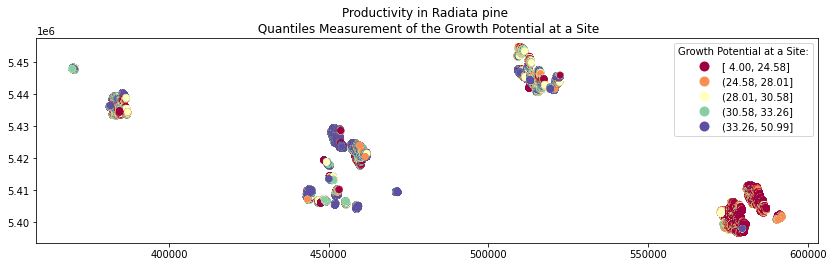

In [ ]:
# 2. MAP 2
fig, ax = plt.subplots(figsize=(14,12), subplot_kw={'aspect':'equal'})

EDAsurvey_point.plot(column="siteindex", scheme='Quantiles', k=5, cmap='Spectral', legend=True, legend_kwds={'title':'Growth Potential at a Site:'}, ax=ax)

# add a title for the plot
ax.set_title("Productivity in Radiata pine \n Quantiles Measurement of the Growth Potential at a Site");

plt.savefig('pointsRadiataTas.jpg', bbox_inches='tight', dpi=300)

## 4 Save new dataframe with geometry points

In [ ]:
from google.colab import  drive

#Mounts the google drive to Colab Notebook
drive.mount('/content/drive', force_remount=True)

#Make sure the folder Name is created in the google drive before uploading
EDAsurvey_point.to_csv('/content/drive/My Drive/EDAsurvey_point/EDAsurvey_point.csv', index = False, header=True)

Mounted at /content/drive


In [ ]:
# Define relative path to file
EDAsurvey_point = pd.read_csv('/content/drive/My Drive/EDAsurvey_point/EDAsurvey_point.csv')
EDAsurvey_point.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT,geometry
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650,POINT (508985 5452015)
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845,POINT (508975 5452035)
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531,POINT (508975 5452045)
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299,POINT (508995 5452005)
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615,POINT (508995 5452015)


# Pre-processing

## 1 Categorical Data

### 1.1 Bayesian Target Encoding with smoothing

### 1.1.1 Option 1

In [ ]:
from category_encoders import BinaryEncoder
import category_encoders as ce

# 1. OPTION 1
binaryEncode = ce.BinaryEncoder(cols=['SYMBOL', 'soil_order'], return_df=True)
binaryEncode 

BinaryEncoder(cols=['SYMBOL', 'soil_order'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)

In [ ]:
#Create object for binary encoding
encoder= ce.BinaryEncoder(cols=['SYMBOL', 'soil_order'],return_df=True)

#Original Data
EDAsurvey

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953551,449395,5418885,32.349624,18.925954,0.018856,-0.000417,3.239803,0.582341,7.393249,650.728638,0.999199,3.356858,0.761295,2.595563,172.463463,18.255143,15.628569,165.353509,23.189606,3.262590,Qh,Ferrosol,0.954301,23.126349,2.926206,0.681001,3.563126,5.458370,48.133842,28.739811
953552,449395,5418895,30.811392,22.140840,0.009678,0.000054,3.026852,0.666098,7.385870,618.063919,0.999298,3.340918,0.761405,2.579513,171.954643,18.245243,15.607247,165.172186,23.194394,3.266210,Qh,Ferrosol,0.955130,22.798484,2.747984,0.683937,3.569947,5.456884,48.532012,28.669504
953553,449395,5418905,30.323318,28.267725,0.009118,0.000773,3.119348,0.786781,7.436504,625.110260,0.999251,3.336639,0.761402,2.575237,171.489864,18.235343,15.585924,164.990858,23.199181,3.269831,Qh,Ferrosol,0.955584,22.590630,2.546336,0.684924,3.575399,5.455206,48.783426,28.625943
953554,449405,5418655,31.950595,48.903477,0.098096,0.003010,3.179998,-0.854446,8.409417,2910.936401,0.999191,3.304150,0.760220,2.543930,187.948654,18.484293,15.935437,168.084494,23.120580,3.204877,Qh,Ferrosol,0.950687,26.219542,4.481331,0.677792,3.506180,5.488909,45.892117,27.888341


### 1.1.2 Option 2

In [82]:
# 2. OPTION 2
def calc_smooth_mean(EDAsurvey, by, on, m):
    # Compute the global mean
    mean = EDAsurvey[on].mean()

    # Compute the number of values and the mean of each group
    agg = EDAsurvey.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return EDAsurvey[by].map(smooth)

In [83]:
EDAsurvey.loc[:, 'SYMBOL'] = calc_smooth_mean(EDAsurvey, by='SYMBOL', on='siteindex', m=29)
EDAsurvey.loc[:, 'soil_order'] = calc_smooth_mean(EDAsurvey, by='soil_order', on='siteindex', m=5)
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


### 1.1.3 For Descriptive Statistics

### a) Extract categorical values encoded

In [ ]:
# soil_order values
mean = EDAsurvey.siteindex.mean()
agg = EDAsurvey.groupby('soil_order')['siteindex'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']

smoothSoil = (counts * means + 5 * mean) / (counts + 5)
smoothSoil

soil_order
Chromosol    30.574759
Dermosol     27.540958
Ferrosol     32.084894
Kurosol      30.859481
Sodosol      28.982688
dtype: float64

In [ ]:
# sort values ascending
smoothSoil.sort_values()

soil_order
Dermosol     27.540958
Sodosol      28.982688
Chromosol    30.574759
Kurosol      30.859481
Ferrosol     32.084894
dtype: float64

In [ ]:
# geology SYMBOL values
mean = EDAsurvey.siteindex.mean()
agg = EDAsurvey.groupby('SYMBOL')['siteindex'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']

smoothGeol = (counts * means + 29 * mean) / (counts + 29)
smoothGeol

SYMBOL
CO      33.183757
COc     28.180196
COs     27.004697
Cda     34.865489
Cds     33.348038
Cdsv    29.596516
Cdt     33.466185
Cqfp    31.326446
Jd      29.033919
Lap     31.131506
Lt      36.485792
Os      33.776136
Ott     31.973525
P       32.503405
Pf      28.160595
Pl      32.498817
Pt      30.529839
Pu      28.007961
Q       27.809453
Qh      31.741513
Qpt     29.204165
Rvc     27.845767
SDp     24.933032
SDpl    32.435114
SDpr    31.015841
SDps    24.697481
SDpy    29.251284
Tb      30.333898
Ts      29.526195
dtype: float64

In [ ]:
# sort GEOLOGY values ascending
smoothGeol.sort_values()

SYMBOL
SDps    24.697481
SDp     24.933032
COs     27.004697
Q       27.809453
Rvc     27.845767
Pu      28.007961
Pf      28.160595
COc     28.180196
Jd      29.033919
Qpt     29.204165
SDpy    29.251284
Ts      29.526195
Cdsv    29.596516
Tb      30.333898
Pt      30.529839
SDpr    31.015841
Lap     31.131506
Cqfp    31.326446
Qh      31.741513
Ott     31.973525
SDpl    32.435114
Pl      32.498817
P       32.503405
CO      33.183757
Cds     33.348038
Cdt     33.466185
Os      33.776136
Cda     34.865489
Lt      36.485792
dtype: float64

### b.1) Plot siteindex group by soil classification

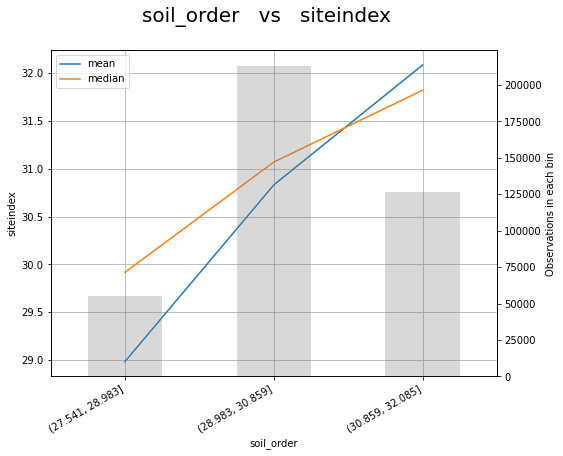

In [ ]:
x, y = "soil_order", "siteindex"

### bin plot
EDAsurvey_noNan = EDAsurvey[EDAsurvey[x].notnull()]
breaks = np.quantile(EDAsurvey_noNan[x], q=np.linspace(0, 1, 11))
groups = EDAsurvey_noNan.groupby([pd.cut(EDAsurvey_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])

fig, ax = plt.subplots()
#fig, ax = plt.subplots(nrows=2, ncols=2,  sharex=False, sharey=False)
#fig.suptitle(x+"   vs   "+y, fontsize=20)
fig.set_size_inches(8, 6)

fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observations in each bin")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

### scatter plot
#sns.jointplot(x=x, y=y, data=EDAsurvey, dropna=True, kind='reg')
plt.savefig('SOILvsSITE.png', bbox_inches='tight', dpi=300)

### b.2) Plot siteindex group by geology structure

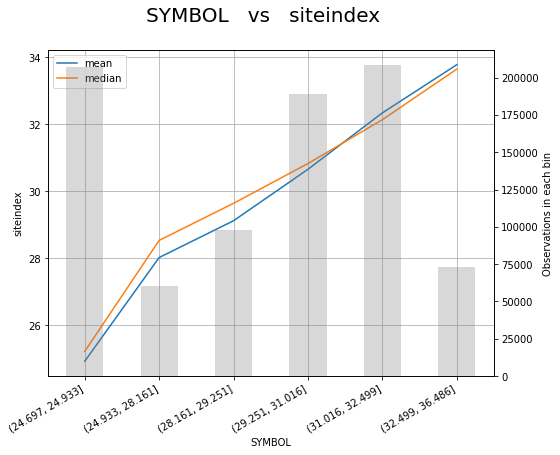

In [ ]:
x, y = "SYMBOL", "siteindex"

### bin plot
EDAsurvey_noNan = EDAsurvey[EDAsurvey[x].notnull()]
breaks = np.quantile(EDAsurvey_noNan[x], q=np.linspace(0, 1, 11))
groups = EDAsurvey_noNan.groupby([pd.cut(EDAsurvey_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])

fig, ax = plt.subplots()
#fig, ax = plt.subplots(nrows=2, ncols=2,  sharex=False, sharey=False)
#fig.suptitle(x+"   vs   "+y, fontsize=20)
fig.set_size_inches(8, 6)

fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observations in each bin")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

### scatter plot
#sns.jointplot(x=x, y=y, data=EDAsurvey, dropna=True, kind='reg')
plt.savefig('GEOLvsSITE.png', bbox_inches='tight', dpi=300)

In [ ]:
import statistics
from scipy import stats

# Use stats. function to describe the mean of observations
stats.describe(EDAsurvey.SYMBOL)

DescribeResult(nobs=953556, minmax=(24.697480600497528, 36.485791999975575), mean=28.962667390307836, variance=10.87790935341574, skewness=-0.08873828140615538, kurtosis=-1.345323336813257)

## 2 Features selection?

### 2.1 Correlation Analysis: Spearman

In [28]:
# 1.create a copy of dataframe
EDAsurveyCORR = EDAsurvey.copy()

# Remove column  RCODE and DESCRIPT for ML
EDAsurveyCORR.drop(['x', 'y'], inplace = True, axis = 1) 
EDAsurveyCORR.head()

,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


In [ ]:
# 2.correlation with Spearman
spearmancorr = EDAsurveyCORR.corr(method='spearman')
spearmancorr

,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
siteindex,1.000000,0.031095,-0.113104,-0.152914,-0.109250,-0.225499,0.215577,0.263748,0.109304,0.124288,-0.114080,0.138781,-0.480185,-0.357393,-0.567263,0.493680,0.040687,0.479417,0.619824,0.349842,-0.374351,0.313318,-0.394741,-0.316842,0.403526,0.099514,-0.155904,-0.024656
aspect,0.031095,1.000000,0.008325,0.024129,0.020777,0.014362,-0.021320,-0.023096,-0.024829,-0.303018,0.028913,-0.342623,0.129647,0.094831,0.099042,-0.031633,-0.023508,-0.071986,-0.105434,-0.052924,0.066600,-0.027509,0.061857,0.058294,-0.068091,-0.053010,0.029981,-0.010560
planCurvature,-0.113104,0.008325,1.000000,0.430254,-0.040650,0.444574,-0.276281,-0.378293,0.041422,0.028265,0.012687,0.018211,0.028098,0.011646,-0.008902,0.025553,-0.009775,0.021413,0.012321,0.026569,-0.013214,-0.004087,-0.009580,-0.001020,0.022764,-0.042422,0.004888,-0.001502
profileCurvature,-0.152914,0.024129,0.430254,1.000000,0.053664,0.524375,-0.246964,-0.387611,-0.054665,-0.016819,-0.002600,-0.011774,0.125581,0.082191,0.049936,-0.003954,-0.067953,-0.047552,-0.058436,-0.019550,-0.007138,-0.072087,0.056167,0.056279,0.015143,-0.105000,0.016931,0.028909
slope,-0.109250,0.020777,-0.040650,0.053664,1.000000,-0.037906,-0.707747,-0.366446,-0.999534,-0.157231,-0.257112,0.001244,0.160963,0.126368,0.118468,-0.034491,0.051913,-0.101223,-0.131773,-0.030860,0.162575,-0.162080,0.051062,0.079121,-0.124926,-0.108045,0.104216,0.002187
TPI,-0.225499,0.014362,0.444574,0.524375,-0.037906,1.000000,-0.435117,-0.679191,0.039918,0.016939,0.026788,-0.001485,0.140014,0.078095,0.037334,0.013706,-0.084777,-0.038512,-0.042498,-0.005764,-0.011918,-0.095425,0.069874,0.056851,0.027039,-0.125518,0.033892,0.025750
TWI_SAGA,0.215577,-0.021320,-0.276281,-0.246964,-0.707747,-0.435117,1.000000,0.874950,0.705461,0.049621,0.128869,-0.050402,-0.164370,-0.082986,-0.076102,-0.000818,-0.067653,0.031445,0.109769,-0.015799,-0.146986,0.144348,-0.075137,-0.026906,0.084072,0.134590,-0.148556,0.062684
catchmentArea_SAGA,0.263748,-0.023096,-0.378293,-0.387611,-0.366446,-0.679191,0.874950,1.000000,0.364026,-0.022910,0.005890,-0.054152,-0.194285,-0.087954,-0.068497,-0.002901,0.001060,0.029877,0.115794,-0.018861,-0.086252,0.139078,-0.120547,-0.022861,0.026690,0.152273,-0.139360,0.064825
SVF_simplified,0.109304,-0.024829,0.041422,-0.054665,-0.999534,0.039918,0.705461,0.364026,1.000000,0.159021,0.259181,0.000288,-0.164907,-0.129367,-0.121046,0.032659,-0.049050,0.100899,0.132810,0.030777,-0.160550,0.160193,-0.049968,-0.079503,0.123155,0.111537,-0.101931,-0.003918
Gh_total,0.124288,-0.303018,0.028265,-0.016819,-0.157231,0.016939,0.049621,-0.022910,0.159021,1.000000,0.604929,0.928411,-0.289948,-0.463202,-0.489901,0.088231,0.460887,0.479500,0.168041,0.402961,-0.043207,0.115397,-0.031169,-0.270716,0.154030,0.149964,0.163133,-0.260665


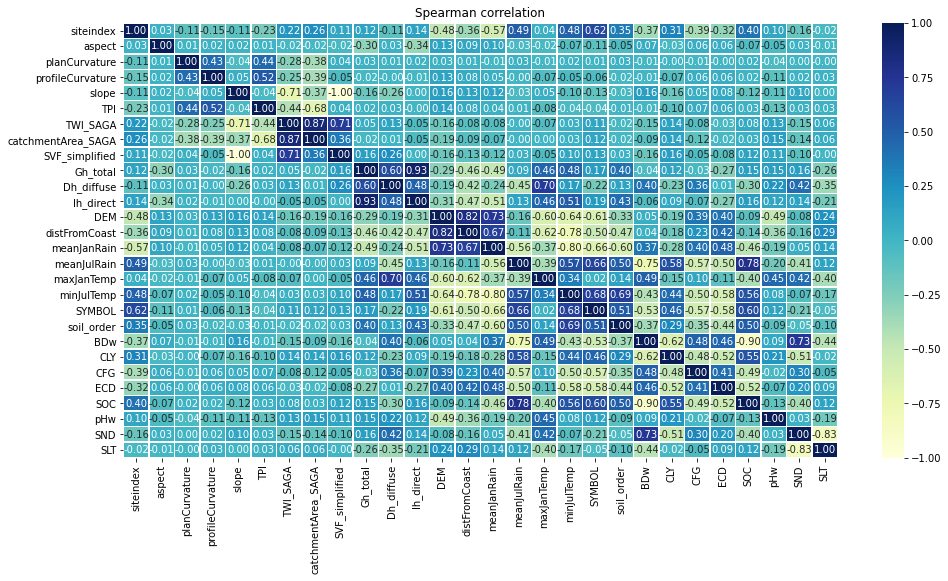

In [29]:
# 3.correlation with Spearman Improved

plt.figure(figsize=(16,8))

corr_matrix = EDAsurveyCORR.corr(method="spearman")

sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Spearman correlation")

plt.savefig('Spearmancorr_EDAsurvey.png', bbox_inches='tight', dpi=300)

### 2.2 Drop features high correlated

In [84]:
# Remove 3 columns: less feature importance
EDAsurvey.drop(columns=['catchmentArea_SAGA', 'SVF_simplified', 'Gh_total', 'distFromCoast'], inplace= True, axis = 1) 
#EDAsurvey.head()

#EDAsurvey.shape
#OUTPUT: (953556, 24)

In [31]:
features= list(EDAsurvey.columns)
features

['x',
 'y',
 'siteindex',
 'aspect',
 'planCurvature',
 'profileCurvature',
 'slope',
 'TPI',
 'TWI_SAGA',
 'Dh_diffuse',
 'Ih_direct',
 'DEM',
 'meanJanRain',
 'meanJulRain',
 'maxJanTemp',
 'minJulTemp',
 'SYMBOL',
 'soil_order',
 'BDw',
 'CLY',
 'CFG',
 'ECD',
 'SOC',
 'pHw',
 'SND',
 'SLT']

## 3 Normalize Data

In [34]:
# drop coordinates
EDAsurvey.drop(columns=['x', 'y'], inplace= True, axis = 1) 

In [32]:
#NORMALIZE
from sklearn.preprocessing import MinMaxScaler

y = EDAsurvey['siteindex']
EDAsurvey = EDAsurvey.loc[:, ~EDAsurvey.columns.isin(['siteindex'])]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(EDAsurvey)
EDAsurvey.loc[:,:] = scaled_values

EDAsurvey['siteindex'] = y

In [35]:
EDAsurvey.head()

,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT,siteindex
0,0.324073,0.445431,0.637699,0.127219,0.524300,0.399242,0.987201,0.974878,0.072357,0.044092,0.184301,0.957136,0.932759,0.409619,0.730319,0.888483,0.236139,0.053705,0.355763,0.038044,0.561864,0.834947,0.185340,27.914452
1,0.271972,0.444238,0.618139,0.117983,0.521429,0.509997,0.988226,0.976873,0.068866,0.042475,0.183347,0.958660,0.934621,0.409619,0.730319,0.889869,0.247779,0.054667,0.368036,0.037626,0.600319,0.836997,0.175913,27.615402
2,0.278898,0.445406,0.610340,0.113273,0.521865,0.530687,0.988683,0.976371,0.067856,0.041899,0.182996,0.959172,0.935292,0.409619,0.730319,0.889948,0.248986,0.054729,0.368189,0.037598,0.602597,0.836463,0.175780,27.474239
3,0.353328,0.445932,0.620043,0.135483,0.523819,0.335656,0.986266,0.973560,0.074708,0.045347,0.185025,0.955888,0.931355,0.409619,0.730319,0.887536,0.228323,0.052748,0.346148,0.038323,0.534801,0.831176,0.194383,27.193528
4,0.336173,0.445418,0.630900,0.131019,0.524329,0.353325,0.986734,0.974377,0.073859,0.044639,0.184609,0.956542,0.932158,0.409619,0.730319,0.887934,0.237401,0.053405,0.345124,0.038164,0.547753,0.827193,0.193354,27.879600


### Boxplot

In [36]:
columns = list(EDAsurvey.columns)
new_column_names = []
for col in columns:
    new_column_names.append(col.replace(' ', '_'))
EDAsurvey.columns = new_column_names

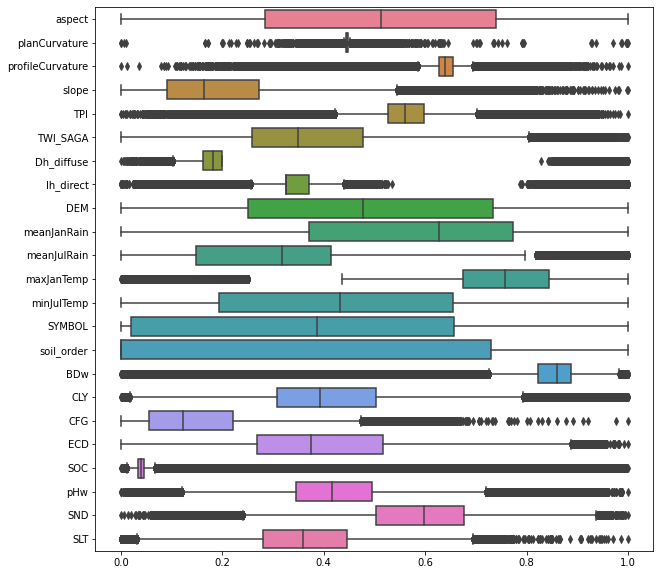

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(data=EDAsurvey.drop(columns=['siteindex']), orient='horizontal', palette='husl')

### Correlation between features

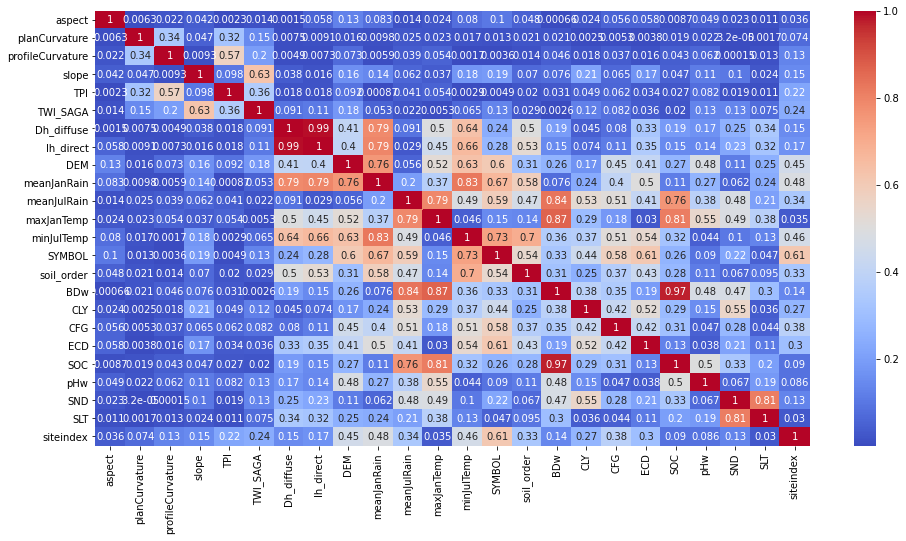

In [38]:
#check correlation after drop 4 features
corr_matrix = EDAsurvey.corr().abs()
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# 4 Fit Model: Ordinary Least Squares(OLS)

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_ols = ols("""siteindex ~ aspect 
                        + planCurvature 
                        + profileCurvature
                        + slope
                        + TPI
                        + TWI_SAGA 
                        + Dh_diffuse
                        + Ih_direct
                        + DEM
                        + meanJanRain
                        + meanJulRain
                        + maxJanTemp
                        + minJulTemp
+ SYMBOL
+ soil_order
+ BDw
+ CLY
+ CFG
+ ECD
+ SOC
+ pHw
+ SND
+ SLT""", data=EDAsurvey).fit()
                      

In [41]:
from IPython.display import HTML, display
from IPython.core import display as ICD

model_summary = model_ols.summary()
HTML(
(model_ols.summary()
    .as_html()
    .replace('<th>Dep. Variable:</th>', '<th style="background-color:#c7e9c0;"> Dep. Variable: </th>')
    .replace('<th>Model:</th>', '<th style="background-color:#c7e9c0;"> Model: </th>')
    .replace('<th>Method:</th>', '<th style="background-color:#c7e9c0;"> Method: </th>')
    .replace('<th>No. Observations:</th>', '<th style="background-color:#c7e9c0;"> No. Observations: </th>')
    .replace('<th>  R-squared:         </th>', '<th style="background-color:#aec7e8;"> R-squared: </th>')
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

In [42]:
print('R2: ', model_ols.rsquared)
print('Parameters: ', model_ols.params)

R2:  0.49133645826432837
Parameters:  Intercept           59.319715
aspect               2.483319
planCurvature      -11.023741
profileCurvature     0.321308
slope               -1.000201
TPI                -15.359761
TWI_SAGA             2.226215
Dh_diffuse         -14.090422
Ih_direct            3.950534
DEM                  7.250034
meanJanRain        -12.867521
meanJulRain          1.154428
maxJanTemp           8.182241
minJulTemp           6.195922
SYMBOL               7.842306
soil_order           0.424008
BDw                 -2.628690
CLY                 -9.151022
CFG                 -0.359629
ECD                  4.282906
SOC                 -5.288607
pHw                 -3.652163
SND                -19.717190
SLT                -18.521066
dtype: float64


In [46]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(EDAsurvey.drop(columns=['siteindex']), y)
y_true = EDAsurvey.siteindex
y_pred = model.predict(EDAsurvey.drop(columns=['siteindex']))

In [47]:
column_names = ['aspect','planCurvature', 'profileCurvature','slope','TPI','TWI_SAGA','Dh_diffuse','Ih_direct','DEM','meanJanRain','meanJulRain','maxJanTemp','minJulTemp','SYMBOL','soil_order','BDw','CLY', 'CFG','ECD','SOC','pHw','SND','SLT']

regression_coefficient = pd.DataFrame({'Feature': column_names, 'Coefficient': model.coef_}, columns=['Feature', 'Coefficient'])

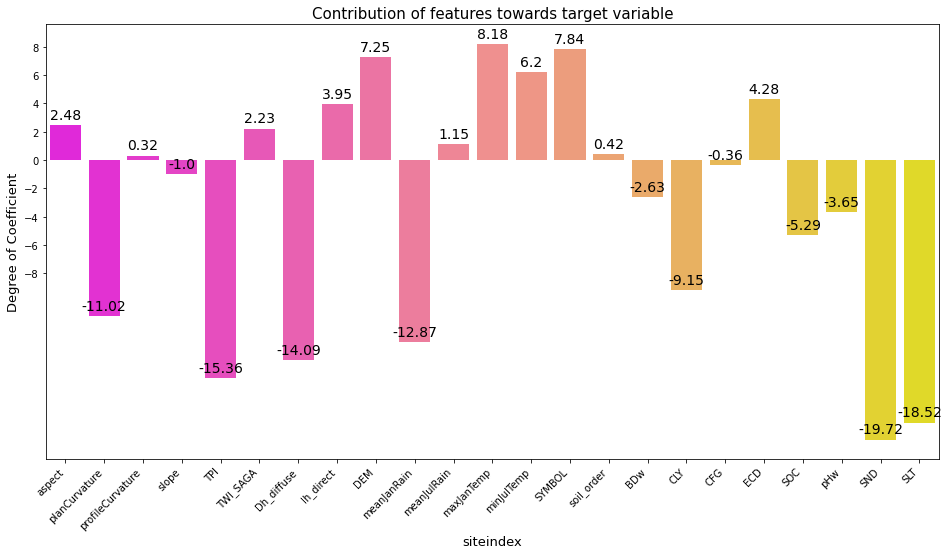

In [48]:
plt.figure(figsize=(16,8))
g = sns.barplot(x='Feature', y='Coefficient', data=regression_coefficient, capsize=0.3, palette='spring')
g.set_title("Contribution of features towards target variable", fontsize=15)
g.set_xlabel("siteindex", fontsize=13)
g.set_ylabel("Degree of Coefficient", fontsize=13)
plt.xticks(rotation=45, horizontalalignment='right')
g.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
g.set_xticklabels(column_names)
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
               textcoords='offset points', fontsize=14, color='black')


plt.savefig('regCoef_linearModel.png', bbox_inches='tight', dpi=300)


# 5 Split into training

## 5.1 Extract train and test idx for later merge with geography coord

In [85]:
# Extracting train and test idx for later merge with additional data or geography coordinates
test_idx=np.asarray(X_test.index)
train_idx=np.asarray(X_train.index)

X_test_coord=EDAsurvey[[ 'x', 'y', 'siteindex']].iloc[test_idx]
X_test_coord.reset_index(inplace=True,drop=True)

test_idx

array([117564, 179982, 277799, ..., 618606, 821433, 577060])

In [ ]:
X_test.shape
#output: (95356, 23)

(95356, 23)

In [ ]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

In [ ]:
# drop coordinates
EDAsurvey.drop(columns=['x', 'y'], inplace= True, axis = 1) 

## 5.2 Split into training: test=10%

In [119]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# axis 1 refers to the columns
X = EDAsurvey.drop('siteindex', axis = 1)

# Saving feature names for later use
X_list = list(EDAsurvey.columns)

# A_Target variable: Labels are the values we want to predict
#y = EDAsurveyML['siteindex']

y = EDAsurvey['siteindex']#.values.reshape(-1,1)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (858200, 23)
Training Labels Shape: (95356, 23)
Testing Features Shape: (858200,)
Testing Labels Shape: (95356,)


In [146]:
EDAsurvey.head()

,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,1.359027,7.344204,54.816718,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,1.359776,7.359235,52.767088,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,1.360110,7.355454,52.174048,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1.358343,7.334274,56.197104,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1.358685,7.340429,55.698914,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


# 6 Fit Model: Linear Model

In [134]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Create a linear regression object
model = linear_model.LinearRegression()

# TRAIN: Fit the model using the training set
model.fit(X_train, y_train)

# TEST: Make prediction using test set
predictedStand = model.predict(X_test)
predictedStand

array([30.01418315, 31.96711781, 23.04287148, ..., 29.71378314,
       33.37232983, 30.58760305])

## 6.1 Evaluation Model: R-squared and regression coeff

In [135]:
from sklearn.metrics import mean_squared_error, r2_score
# Model Output
# a. Coefficient - the slop of the line
print("Coefficients(slope of the line):", model.coef_)

# b. the error - the mean square error
print("Mean squared error: %.2f"% mean_squared_error(y_test,predictedStand))

# c. R-square -  how well x accout for the varaince of Y
print("R-square: %.2f'" % r2_score(y_test,predictedStand))

Coefficients(slope of the line): [ 1.38414042e-02 -1.28530707e+00  3.53550649e+00 -2.29134397e-02
 -3.57959420e-01  2.14557835e-01 -1.94293402e+01  5.34889483e-01
  1.24794804e-02 -4.35188997e-01  6.37663062e-03  1.71422689e+00
  1.32294040e+00  6.65955903e-01  9.46133545e-02 -3.30669210e+00
 -2.28531272e-01 -1.43795303e-02  3.82661396e+00 -1.36871295e-01
 -2.07827358e+00 -2.66440485e-01 -2.84389327e-01]
Mean squared error: 14.87
R-square: 0.49'


In [114]:
#CHANGE cell below to transpose index
#y = EDAsurvey['siteindex'].values.reshape(-1,1)

pred_model = pd.DataFrame(['aspect','planCurvature','profileCurvature','slope','TPI','TWI_SAGA','Dh_diffuse','Ih_direct','DEM','meanJanRain','meanJulRain','maxJanTemp','minJulTemp','SYMBOL','soil_order','BDw','CLY','CFG','ECD','SOC','pHw','SND','SLT'])
coeff = pd.DataFrame(model.coef_, index=['Co-efficient']).transpose() 

In [115]:
pd.concat([pred_model,coeff], axis=1, join='inner')

,0,Co-efficient
0,aspect,0.013841
1,planCurvature,-1.285307
2,profileCurvature,3.535506
3,slope,-0.022913
4,TPI,-0.357959
5,TWI_SAGA,0.214558
6,Dh_diffuse,-19.429340
7,Ih_direct,0.534889
8,DEM,0.012479
9,meanJanRain,-0.435189


### 6.1.0 Plot Evaluation Model

In [ ]:
column_names = ['aspect','planCurvature', 'profileCurvature','slope','TPI','TWI_SAGA','Dh_diffuse','Ih_direct','DEM','meanJanRain','meanJulRain','maxJanTemp','minJulTemp','SYMBOL','soil_order','BDw','CLY', 'CFG','ECD','SOC','pHw','SND','SLT']

regression_coefficient = pd.DataFrame({'Feature': column_names, 'Coefficient': model.coef_}, columns=['Feature', 'Coefficient'])

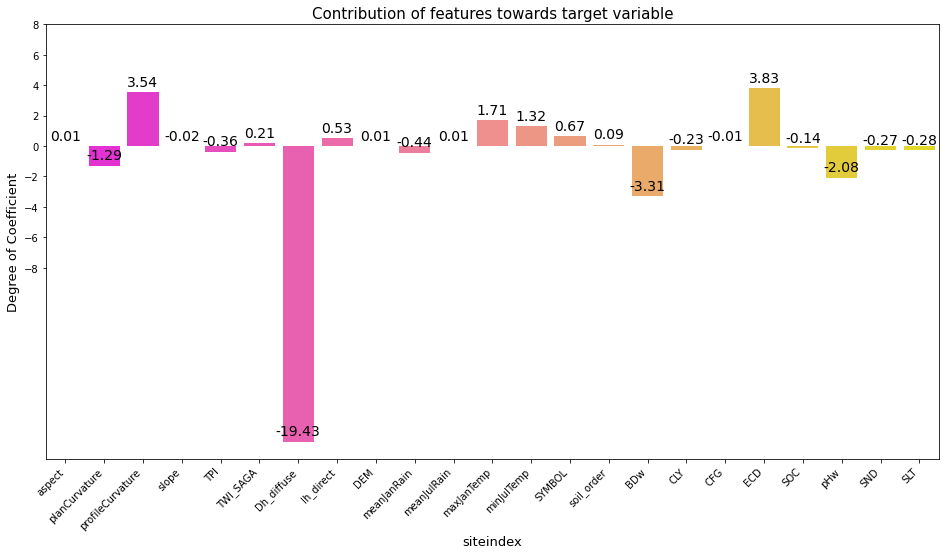

In [ ]:
plt.figure(figsize=(16,8))
g = sns.barplot(x='Feature', y='Coefficient', data=regression_coefficient, capsize=0.3, palette='spring')
g.set_title("Contribution of features towards target variable", fontsize=15)
g.set_xlabel("siteindex", fontsize=13)
g.set_ylabel("Degree of Coefficient", fontsize=13)
plt.xticks(rotation=45, horizontalalignment='right')
g.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
g.set_xticklabels(column_names)
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
               textcoords='offset points', fontsize=14, color='black')


plt.savefig('regCoef_linearModel_10test.png', bbox_inches='tight', dpi=300)

### 6.1.1 Set perfomance: Actual vs Predicted

In [143]:
#Investigating Train set performance
model.score(X_train, y_train)

0.49140150167009433

In [144]:
#Investigating Test set performance
model.score(X_test, y_test)

0.49073063936931494

In [137]:
dataStand = pd.DataFrame({'Actual': y_test, 'Predicted': predictedStand})
dataStand

,Actual,Predicted
0,29.798079,30.014183
1,28.879247,31.967118
2,27.322234,23.042871
3,29.842022,32.206670
4,30.825058,32.043294
...,...,...
95351,37.443234,31.925386
95352,30.799754,29.819726
95353,34.237284,29.713783
95354,42.999237,33.372330


### 6.1.2 Bar Plot: Actual vs Predicted

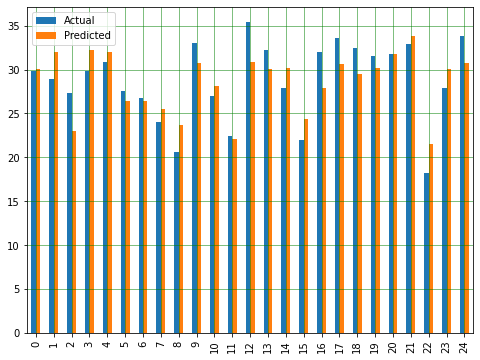

In [138]:
import numpy as np   # To perform calculations
import matplotlib.pyplot as plt  # To visualize data and regression line
from pylab import rcParams
#plt.rcParams['figure.figsize'] = (8, 6)
#sns.set_context(font_scale = 0.5)

dfStand = dataStand.head(25)
dfStand.plot(kind='bar', figsize=(8,6))

plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### 6.1.3 More Validations

In [139]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predictedStand), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predictedStand)/predictedStand)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predictedStand)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictedStand))))

## residuals
residuals = y_test - predictedStand
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predictedStand[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.49
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 3
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 4
Max Error: -29


### Plot Validation: Predicted vs True (Residuals)

/usr/local/lib/python3.6/dist-packages/statsmodels/graphics/regressionplots.py:827: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.canvas.draw()


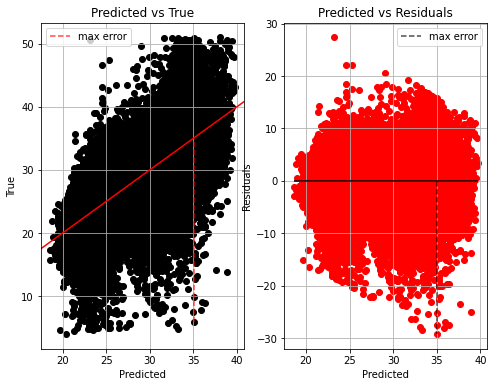

In [140]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,6))

from statsmodels.graphics.api import abline_plot

ax[0].scatter(predictedStand, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(predictedStand, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predictedStand), xmax=np.max(predictedStand))
ax[1].legend()
plt.show()

# 7 Regression assumptions

In [147]:
error = y_true - y_pred
error_info = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'error': error}, columns=['y_true', 'y_pred', 'error'])

## 7.1 Correlation of errors

Text(0, 0.5, 'Residual')

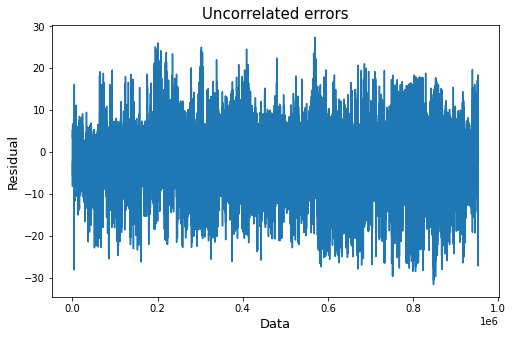

In [148]:
fig, ax = plt.subplots(figsize=(8,5))
ax = error_info.error.plot()
ax.set_title('Uncorrelated errors', fontsize=15)
ax.set_xlabel("Data", fontsize=13)
ax.set_ylabel("Residual", fontsize=13)

## 7.2 Normality of error terms: Probability Plot




Text(0, 0.5, 'Ordered Values')

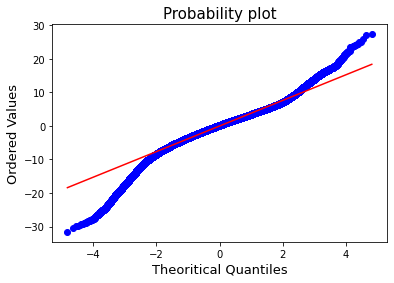

In [149]:
#plotting probability probability plot(p-p plot) 
import scipy as sp

fig, ax = plt.subplots(figsize=(6,4))
_ = sp.stats.probplot(error_info.error, plot=ax, fit=True)
ax.set_title('Probability plot', fontsize=15)
ax.set_xlabel("Theoritical Quantiles", fontsize=13)
ax.set_ylabel("Ordered Values", fontsize=13)


In [ ]:
r2_linear_regression = model_ols.rsquared

model_ridge=linear_model.Ridge()
model_ridge.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y_predict_ridge = model_ridge.predict(EDAsurvey.drop(columns=['siteindex']))
r2_ridge = r2_score(y_true, y_predict_ridge)

model_lasso=linear_model.Lasso()
model_lasso.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y_predict_lasso = model_lasso.predict(EDAsurvey.drop(columns=['siteindex']))
r2_score(y_true, y_predict_lasso)

n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y_predict_knn=knn.predict(EDAsurvey.drop(columns=['siteindex']))
r2_knn = r2_score(y_true, y_predict_knn)

reg = linear_model.BayesianRidge()
reg.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y_pred_reg=reg.predict(EDAsurvey.drop(columns=['siteindex']))
r2_bayesian = r2_score(y_true, y_pred_reg)

dec = tree.DecisionTreeRegressor(max_depth=6)
dec.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y1_dec=dec.predict(EDAsurvey.drop(columns=['siteindex']))
r2_dt = r2_score(y_true, y1_dec)

svm_reg=svm.SVR()
svm_reg.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y1_svm=svm_reg.predict(EDAsurvey.drop(columns=['siteindex']))
r2_svm = r2_score(y_true, y1_svm)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

r2_list = [r2_linear_regression, r2_ridge, r2_knn, r2_dt, r2_bayesian, r2_svm]
r2_names = ['Linear Regression', 'Ridge Regression', 'KNN', 'Decision Tree', 'Bayesian Regression', 'SVM']

col = {'R-squared':r2_list, 'Method':r2_names}
df = pd.DataFrame(data=col, columns=['Method', 'R-squared'])



NameError: ignored